### Assignment - 1

#### 1. Load and Inspect the CMAPSS Dataset
Task:
- Write Python code to load the raw `train_FD001.txt` dataset for CMAPSS using Pandas, assign appropriate column names, and display the shape, data types, and first 5 rows of the DataFrame.
- Expected Output: DataFrame shape, info, and sample rows.

Use the link to download the dataset:
https://data.nasa.gov/dataset/cmapss-jet-engine-simulated-data

In [8]:
import pandas as pd
import numpy as np
from pathlib import Path
column_names = (
    ["engine_id", "cycle", "op_setting_1", "op_setting_2", "op_setting_3"]
    + [f"sensor_{i}" for i in range(1, 22)]
)
file_path = Path("../../..") / "data" / "raw" / "train_FD001.txt"
df= pd.read_csv(file_path, sep=r"\s+", header=None, names=column_names)

print("Shape:", df.shape)
print("\nDataFrame info:", df.info())
print("\nFirst 5 Rows:\n", df.head())

Shape: (20631, 26)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   engine_id     20631 non-null  int64  
 1   cycle         20631 non-null  int64  
 2   op_setting_1  20631 non-null  float64
 3   op_setting_2  20631 non-null  float64
 4   op_setting_3  20631 non-null  float64
 5   sensor_1      20631 non-null  float64
 6   sensor_2      20631 non-null  float64
 7   sensor_3      20631 non-null  float64
 8   sensor_4      20631 non-null  float64
 9   sensor_5      20631 non-null  float64
 10  sensor_6      20631 non-null  float64
 11  sensor_7      20631 non-null  float64
 12  sensor_8      20631 non-null  float64
 13  sensor_9      20631 non-null  float64
 14  sensor_10     20631 non-null  float64
 15  sensor_11     20631 non-null  float64
 16  sensor_12     20631 non-null  float64
 17  sensor_13     20631 non-null  float64
 18  sensor_

#### 2. Visualize Sensor Distributions and Identify Missing Values
Task:
- Using the loaded dataset (or the cleaned version), visualize the distribution of values for any three sensor columns with histograms, and check for missing values in all columns.
- Expected Output: Three histogram plots and a summary/report on missing values per column.

In [2]:
missing_values= df.isnull().sum()
print("Missing Values: ", missing_values)

Missing Values:  engine_id       0
cycle           0
op_setting_1    0
op_setting_2    0
op_setting_3    0
sensor_1        0
sensor_2        0
sensor_3        0
sensor_4        0
sensor_5        0
sensor_6        0
sensor_7        0
sensor_8        0
sensor_9        0
sensor_10       0
sensor_11       0
sensor_12       0
sensor_13       0
sensor_14       0
sensor_15       0
sensor_16       0
sensor_17       0
sensor_18       0
sensor_19       0
sensor_20       0
sensor_21       0
dtype: int64


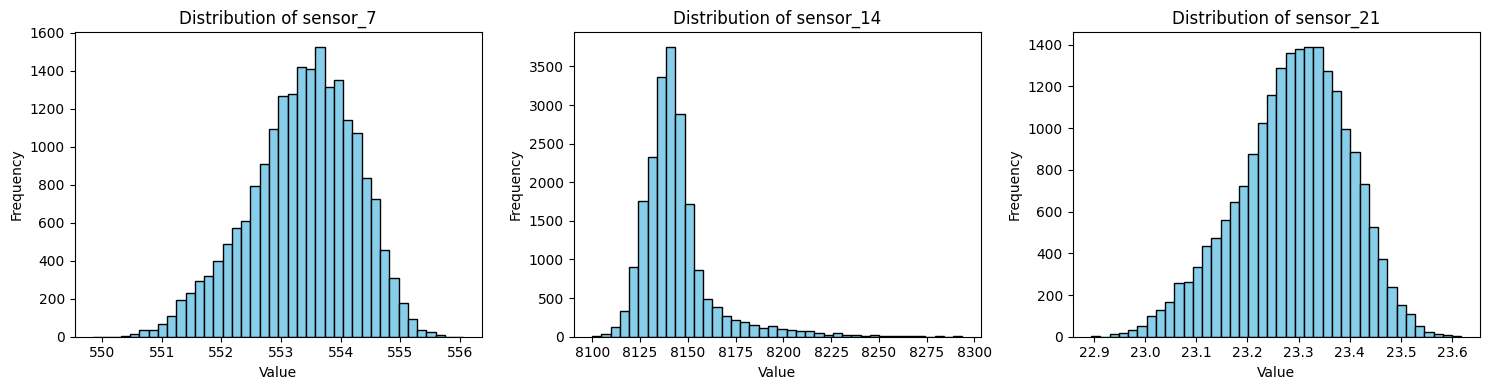

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sensor_cols = ['sensor_7', 'sensor_14', 'sensor_21']

plt.figure(figsize=(15, 4))

for i, col in enumerate(sensor_cols, 1):
    plt.subplot(1, 3, i)
    plt.hist(df[col], bins=40, edgecolor='black', color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

#### 3. Feature Engineering – Aggregation and Rolling Statistics
Task:
- For a selected sensor (e.g., `sensor_2`), compute and append to the DataFrame:
  - The mean and standard deviation of `sensor_2` by each `engine_id`

  - The rolling mean (window size=5) for each engine’s `sensor_2` readings
- Expected Output: Show a few sample rows with these new features.

In [4]:
engine_aggs = df.groupby('engine_id')['sensor_2'].agg(['mean', 'std'])
engine_aggs.columns = [''.join(col) for col in engine_aggs.columns]
engine_aggs.reset_index(inplace=True)
print(f"Aggregate feature matrix shape: {engine_aggs.shape}")
engine_aggs.tail()

Aggregate feature matrix shape: (100, 3)


,engine_id,mean,std
95,96,642.629821,0.501021
96,97,642.522624,0.473922
97,98,642.584872,0.525905
98,99,642.611081,0.502209
99,100,642.741250,0.460405


In [5]:
df['sensor_2_rollmean5'] = df.groupby('engine_id')['sensor_2'].rolling(window=5, min_periods=1).mean().reset_index(level=0, drop=True)
df['sensor_2_rollstd5'] = df.groupby('engine_id')['sensor_2'].rolling(window=5, min_periods=1).std().reset_index(level=0, drop=True)
df[['sensor_2', 'sensor_2_rollmean5', 'sensor_2_rollstd5']].head(10)

,sensor_2,sensor_2_rollmean5,sensor_2_rollstd5
0,641.82,641.820000,NaN
1,642.15,641.985000,0.233345
2,642.35,642.106667,0.267644
3,642.35,642.167500,0.250117
4,642.37,642.208000,0.234776
5,642.10,642.264000,0.128374
6,642.48,642.330000,0.139463
7,642.56,642.372000,0.174270
8,642.12,642.326000,0.208519
9,641.71,642.194000,0.340705


#### 4. Data Normalization
Task:
- Normalize all sensor columns in the DataFrame using `StandardScaler` from `scikit-learn` (zero mean, unit variance) and create a new DataFrame, maintaining the original `engine_id` and `cycle` columns.
- Expected Output: Head of the normalized DataFrame and a check that means are close to zero, std are close to one.

In [6]:
from sklearn.preprocessing import StandardScaler

features_to_scale = [col for col in df.columns if ('sensor_'in col) or ('roll' in col)]


scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[features_to_scale] = scaler.fit_transform(df[features_to_scale])

df_scaled[features_to_scale].describe().T[['mean', 'std']]

,mean,std
sensor_1,0.000000e+00,0.000000
sensor_2,6.410348e-14,1.000024
sensor_3,-1.249503e-14,1.000024
sensor_4,9.147407e-16,1.000024
sensor_5,-5.329071e-15,0.000000
sensor_6,-1.353687e-12,1.000024
sensor_7,-3.159162e-14,1.000024
sensor_8,1.008276e-12,1.000024
sensor_9,-4.185214e-14,1.000024
sensor_10,0.000000e+00,0.000000


#### 5. Rolling Window Sequence Generation
Task:
- Write a function to generate rolling window sequences of length 30 for the sensors of each engine. Save the resulting 3D NumPy array (num_sequences, window_size, num_features), and save the corresponding engine_id and cycle identifier lists as CSV files. Print the shape of the resulting sequence array and contents of the first entry.
- Expected Output: Array shape, example content, and confirmation of successful file saves.